In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from copy import deepcopy
from math import sqrt, cos, acos, ceil
from functools import partial
from random import sample, choices, random
from typing import List, Tuple, Callable
import time

In [2]:
def proper_round(num, dec=0)->float:
    return round(num, dec)

In [3]:
def DistanceBetweenPoints(Pi: List[float], Pf: List[float]) -> int:
  return int(proper_round(sqrt((Pf[0] - Pi[0]) * (Pf[0] - Pi[0]) + (Pf[1] - Pi[1]) * (Pf[1] - Pi[1]))))

In [4]:
def GEOtoLL(Pt: Tuple[float, float]) -> Tuple[float, float]:
  PI = 3.141592
  deg = int(Pt[0])
  min = Pt[0] - deg
  radX = PI * (deg + 5.0 * min/ 3.0) / 180.0

  deg = int(Pt[1])
  min = Pt[1] - deg
  radY = PI * (deg + 5.0 * min/ 3.0) / 180.0

  return radX, radY

In [5]:
def DistanceBetweenLL(Pi: List[float], Pf: List[float]) -> int:
  RRR = 6378.388
  q1 = cos(Pi[0] - Pf[0])
  q2 = cos(Pi[1] - Pf[1])
  q3 = cos(Pi[1] + Pf[1])
  
  return int(RRR * acos( 0.5*((1.0+q1)*q2 - (1.0-q1)*q3) ) + 1.0)

In [6]:
def showGraph(Vetor: List[int], pontos: List[Tuple[float, float]], showCord: bool = False) -> None: #Função para plotar os gráficos
  #Distruibção dos pontos em dois vetores X e Y
  X, Y = [], []
  for i in Vetor:
    X.append(pontos[i][0])
    Y.append(pontos[i][1])
    if showCord:
      print(f'X: {X[-1]:3} - Y: {Y[-1]}')
  
  AuxX, AuxY = [], []
  AuxX.append(X[0])
  AuxX = AuxX + X[1:] + AuxX
  AuxY.append(Y[0])
  AuxY = AuxY + Y[1:] + AuxY

  plt.figure(figsize=(12,12))
  plt.plot(AuxX, AuxY, color='black', alpha=1)
  plt.scatter(X, Y, color='red', s=15)#Plot dos pontos
  plt.grid()
  plt.show()

In [7]:
def GxT(X: List[int], Y: List[float]) -> None:
  plt.figure(figsize=(25,7))
  plt.plot(X, Y)
  plt.grid()
  plt.xlabel('Generation')
  plt.ylabel('Time')
  plt.title('total time: ' + str(sum(Y)),
            fontsize=12,
            color='red',
            loc='right')
  plt.show()

In [8]:
def GxE(X: List[int], Y: List[int]) -> None:
  plt.figure(figsize=(25,7))
  plt.plot(X, Y)
  plt.grid()
  plt.xlabel('Generation')
  plt.ylabel('Distance')
  plt.show()

# Outra abordagem

In [10]:
Pts = List[List[int]]
Individuo = List[int]
Populacao = List[Individuo]
FitnessFunc = Callable[[Individuo], int]
PopulationFunc = Callable[[], Populacao]
SelectFunc = Callable[[Populacao, Pts, FitnessFunc], Tuple[Individuo, Individuo]]
CrossOverFunc = Callable[[Individuo, Individuo], Tuple[Individuo, Individuo]]
MutationFunc = Callable[[Individuo], Individuo]

In [11]:
def GenerateInd(pontos: List[int]) -> Individuo:
  return sample(pontos, len(pontos))

In [12]:
def GenPop(pontos: Pts, Tam: int) -> Populacao:
  return [GenerateInd([i for i in range(len(pontos))]) for _ in range(Tam)]

In [13]:
def Fitness(individuo: Individuo, pontos: Pts) -> int:
  if len(individuo) != len(pontos):
    raise ValueError('Tamanhos diferentes')
  
  Dist = 0
  for i in range(1, len(individuo)):
    Dist += pontos[individuo[i-1]][individuo[i]]
    
  return Dist + pontos[individuo[0]][individuo[-1]]

In [14]:
def SelectNew(population: Populacao, worst: int, pontos: Pts, fitness_func: FitnessFunc) -> Populacao:
  return choices(
      population=population,
      weights=[worst-fitness_func(individuo=individuo) for individuo in population],
      k=2
  )

In [15]:
def CrossOver(a: Individuo, b: Individuo) -> Tuple[Individuo, Individuo]:
  if len(a) != len(b):
    raise ValueError('Tamanhos diferentes')
  N = len(a)
  p1, p2 = randint(0, N-1), randint(0, N-1)
  while p1 == p2: p2 = randint(0, N-1)
  NewInd1 = a[p1:p2]
  NewInd2 = b[p1:p2]

  for i in range(N):
    P = b[i]
    if P not in NewInd1:
      NewInd1.append(P)
  for i in range(N):
    P = a[i]
    if P not in NewInd2:
      NewInd2.append(P)

  return NewInd1, NewInd2

In [16]:
def Mutation(individuo: Individuo, pontos: Pts) -> Individuo:
  improve = True
  while improve:
    N = len(individuo)
    min_change, DistAux = 0, Fitness(individuo, pontos)

    improve = False
    for i in range(N - 2):
      for j in range(i + 2, N-1):
        change = (pontos[individuo[i]][individuo[j]] + pontos[individuo[i+1]][individuo[j+1]]
                - pontos[individuo[i]][individuo[i+1]] - pontos[individuo[j]][individuo[j+1]])
        if change < min_change:
          min_change = change
          min_i, min_j = i, j
    if min_change < 0:
      individuo[min_i+1:min_j+1] = individuo[min_i+1:min_j+1][::-1]
    if DistAux > Fitness(individuo, pontos):
      improve = True
  return individuo

In [17]:
def Mutation1(individuo: Individuo, pontos: Pts) -> Individuo:
  N = len(individuo)
  p1, p2 = randint(0, N-1), randint(0, N-1)
  while p1 == p2: p2 = randint(0, N-1) # if p1 == p2: p2 += 1

  if p1 > p2: p1, p2 = p2, p1
  
  return individuo[:p1] + individuo[p1:p2][::-1] + individuo[p2:]

In [18]:
def run_evo(
    populate_func: PopulationFunc,
    fitness_func: FitnessFunc,
    fitness_limit: int,
    Dists: Pts,
    selection_func: SelectFunc = SelectNew,
    crossover_func: CrossOverFunc = CrossOver,
    mutation_func: MutationFunc = Mutation,
    generation_limit: int = 100,
    show_progress: bool = False,
    croosover_point: int = 0.5,
    mutation_point: int = 0.35
) -> Tuple[Populacao, int, List[int], List[int], List[int]]:
  population = populate_func()
  start, stop, VetT, VetG, results = 0, 0, [], [], []
  for i in range(generation_limit):
    population = sorted(
        population,
        key=lambda individuo: fitness_func(individuo=individuo)
    )

    if show_progress:
      print(f'Generation: {i}. Result: {fitness_func(individuo=population[0])}. Time: {stop-start}')
    VetT.append(stop-start)
    VetG.append(i)
    results.append(fitness_func(individuo=population[0]))
    if fitness_func(individuo=population[0]) <= fitness_limit:
      break

    start = time.time()
    next_gen = population[:2]
    worst = fitness_func(population[-1])
    for _ in range(int(len(population)/2)-1):
      parents = selection_func(population=population, worst=worst, pontos=Dists, fitness_func=fitness_func)
      if random() > croosover_point:
        sobrevivente_a, sobrevivente_b = crossover_func(a=parents[0], b=parents[1])
        if random() > mutation_point:
          sobrevivente_a = mutation_func(individuo=sobrevivente_a, pontos=Dists)
          sobrevivente_b = mutation_func(individuo=sobrevivente_b, pontos=Dists)
        next_gen += [sobrevivente_a, sobrevivente_b]
      else:
        if random() > mutation_point:
          parents[0] = mutation_func(individuo=parents[0], pontos=Dists)
          parents[1] = mutation_func(individuo=parents[1], pontos=Dists)
        next_gen += [parents[0], parents[1]]
    population = deepcopy(next_gen)

    stop = time.time()

  population = sorted(
        population,
        key=lambda individuo: fitness_func(individuo=individuo)
    )

  return population, i, VetT, VetG, results

In [51]:
Pt = []
file = open("./kroA100.tsp")
for line in file:
  if line == 'EOF\n': break
  if line == '\n': continue
  aux = line.split()
  pt = [float(aux[1]), float(aux[2])]
  if pt not in Pt:
    Pt.append(pt)

In [28]:
for i in range(len(Pt)):
  Pt[i] = GEOtoLL(Pt[i])

In [52]:
Distances = []
for i in range(len(Pt)):
  Distance = []
  for j in range(len(Pt)):
    if i == j:
      Distance.append(0)
    else:
      Distance.append(DistanceBetweenPoints(Pt[i], Pt[j]))
  Distances.append(deepcopy(Distance))

In [29]:
Distances = []
for i in range(len(Pt)):
  Distance = []
  for j in range(len(Pt)):
    if i == j:
      Distance.append(0)
    else:
      Distance.append(DistanceBetweenLL(Pt[i], Pt[j]))
  Distances.append(deepcopy(Distance))

In [60]:
population, generation, VetT, VetG, VetR = run_evo(
    populate_func=partial(
        GenPop, pontos=Distances, Tam=50
    ),
    fitness_func=partial(
        Fitness, pontos=Distances
    ),
    Dists=Distances,
    mutation_func=Mutation,
    fitness_limit=21282,
    generation_limit=425,
    show_progress=True
)

Generation: 0. Result: 148441. Time: 0
Generation: 1. Result: 22875. Time: 4.310472726821899
Generation: 2. Result: 22030. Time: 0.43581056594848633
Generation: 3. Result: 22030. Time: 0.3779942989349365
Generation: 4. Result: 22030. Time: 0.36461472511291504
Generation: 5. Result: 22030. Time: 0.24638032913208008
Generation: 6. Result: 21919. Time: 0.15814828872680664
Generation: 7. Result: 21919. Time: 0.13190317153930664
Generation: 8. Result: 21919. Time: 0.20311665534973145
Generation: 9. Result: 21852. Time: 0.6253299713134766
Generation: 10. Result: 21852. Time: 0.21244120597839355
Generation: 11. Result: 21852. Time: 0.2074882984161377
Generation: 12. Result: 21852. Time: 0.18649625778198242
Generation: 13. Result: 21809. Time: 0.3101799488067627
Generation: 14. Result: 21809. Time: 0.2588374614715576
Generation: 15. Result: 21809. Time: 0.18447136878967285
Generation: 16. Result: 21809. Time: 0.2812833786010742
Generation: 17. Result: 21533. Time: 0.22240185737609863
Generatio

In [61]:
Fitness(population[0], Distances)

21282

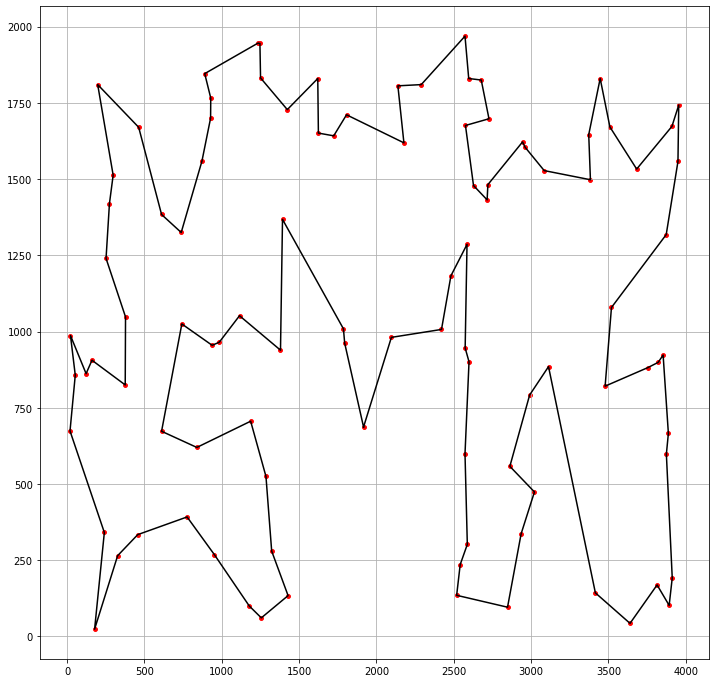

In [62]:
showGraph(Vetor=population[0], pontos=Pt)

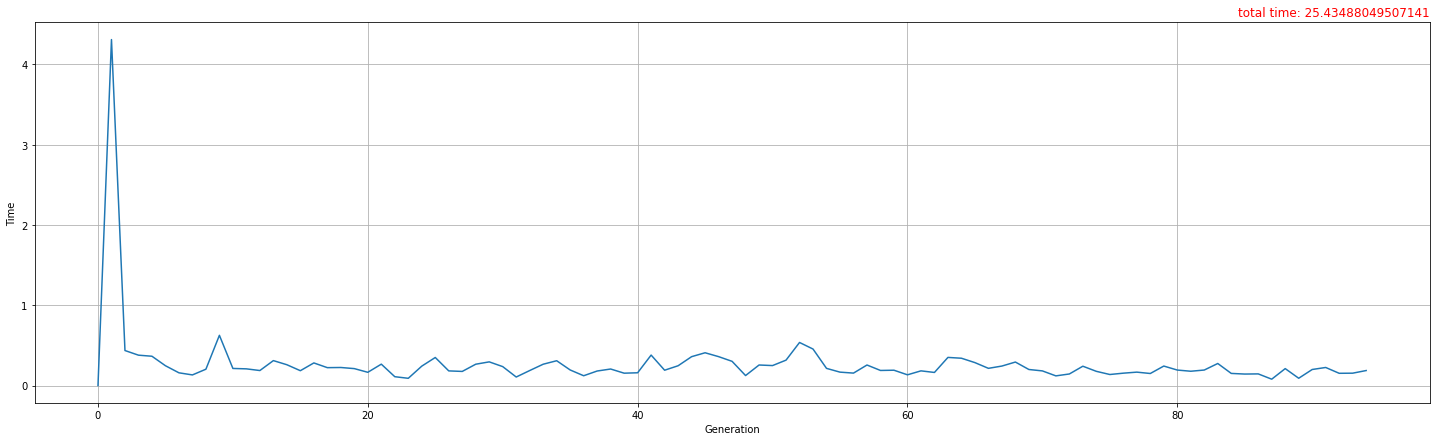

In [63]:
GxT(VetG, VetT)

# Resultados

## pr299

In [ ]:
Fitness(population[0], Distances)

48273

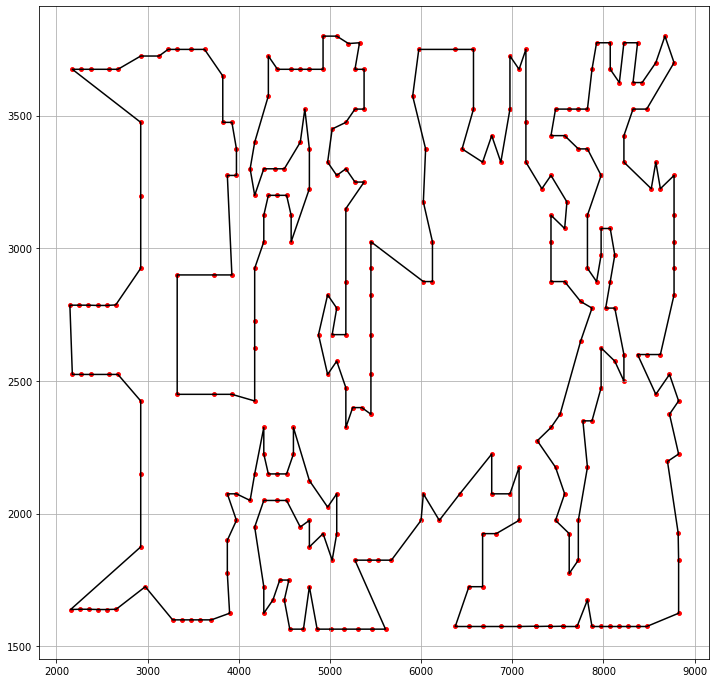

In [ ]:
showGraph(Vetor=population[0], pontos=Pt)

In [ ]:
len(set(population[0]))

299

In [ ]:
len(Pt)

299

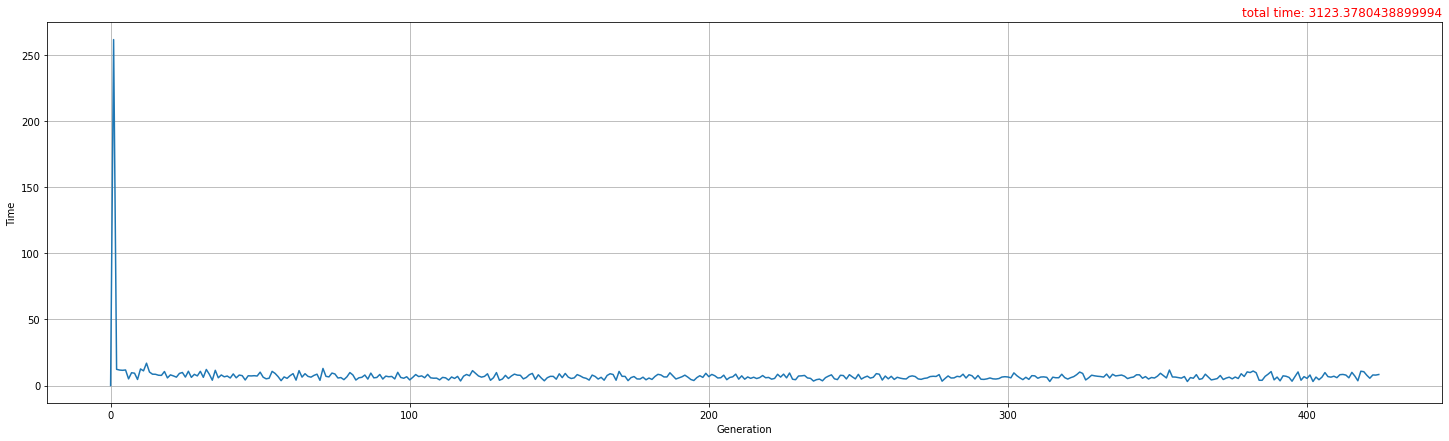

In [ ]:
GxT(VetG, VetT)

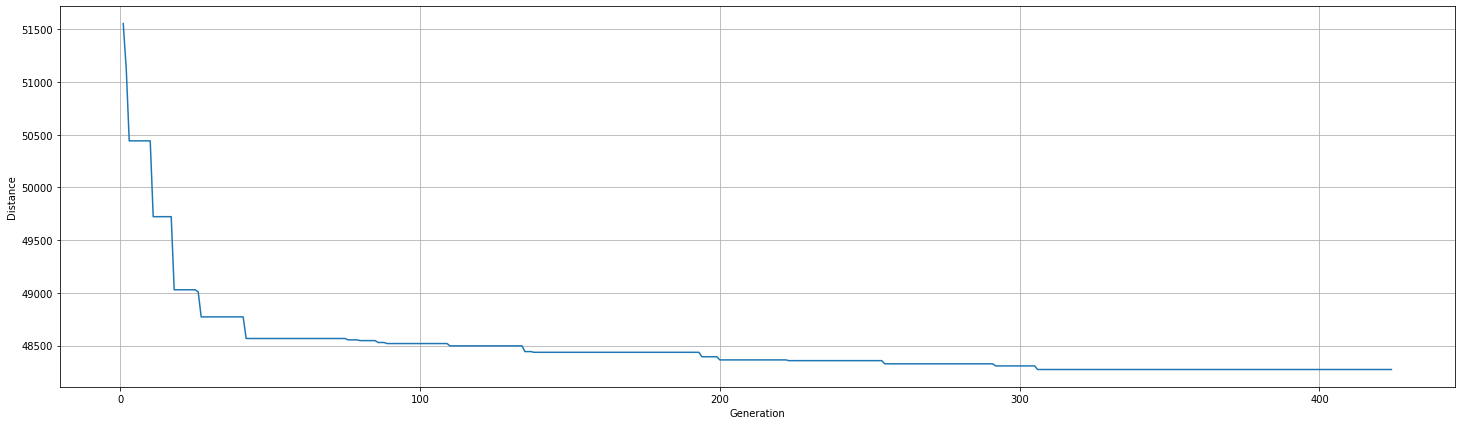

In [ ]:
GxE(VetG[1:], VetR[1:])

## wi29

In [ ]:
Fitness(population[0], Distances)

27603

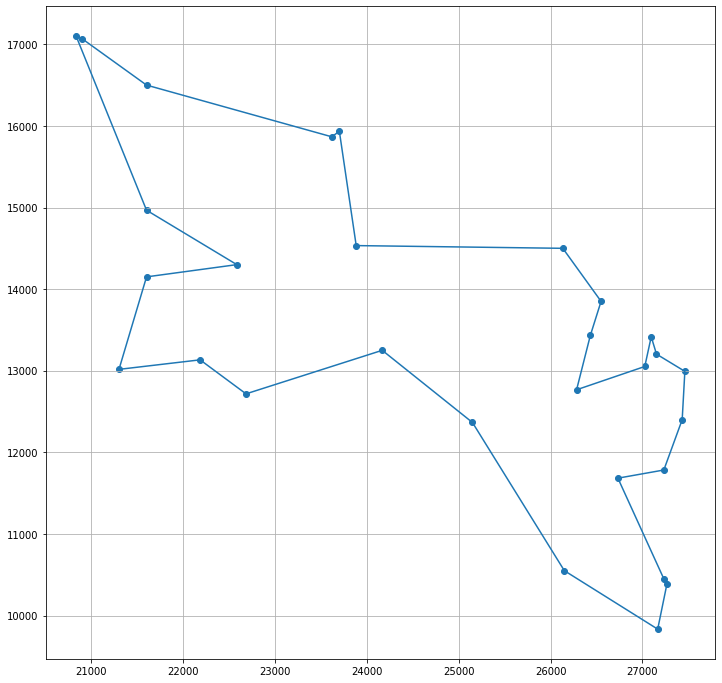

In [ ]:
showGraph(Vetor=population[0], pontos=Pt)

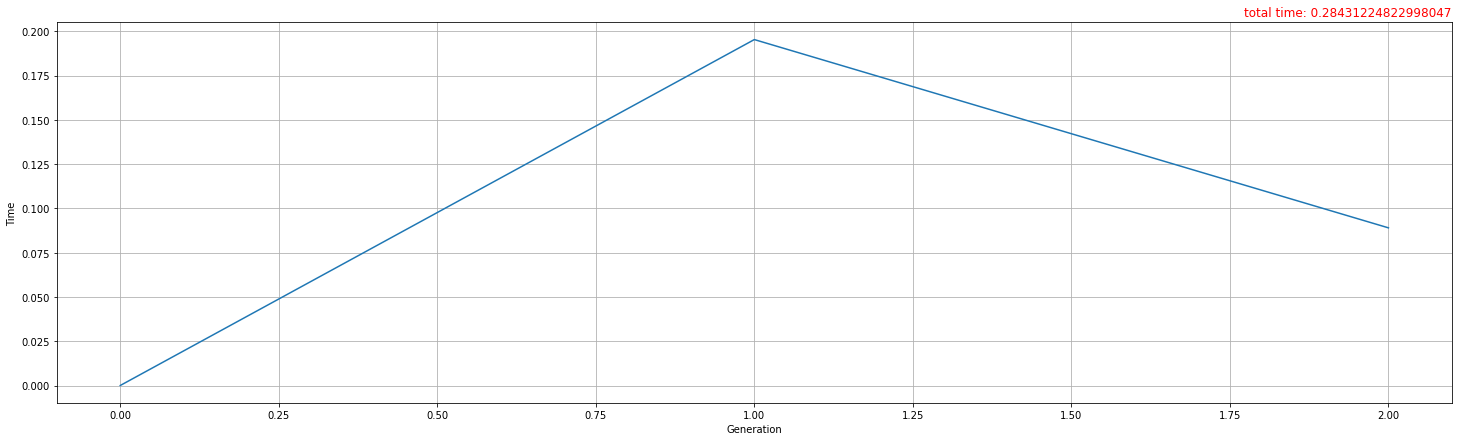

In [ ]:
GxT(VetG, VetT)

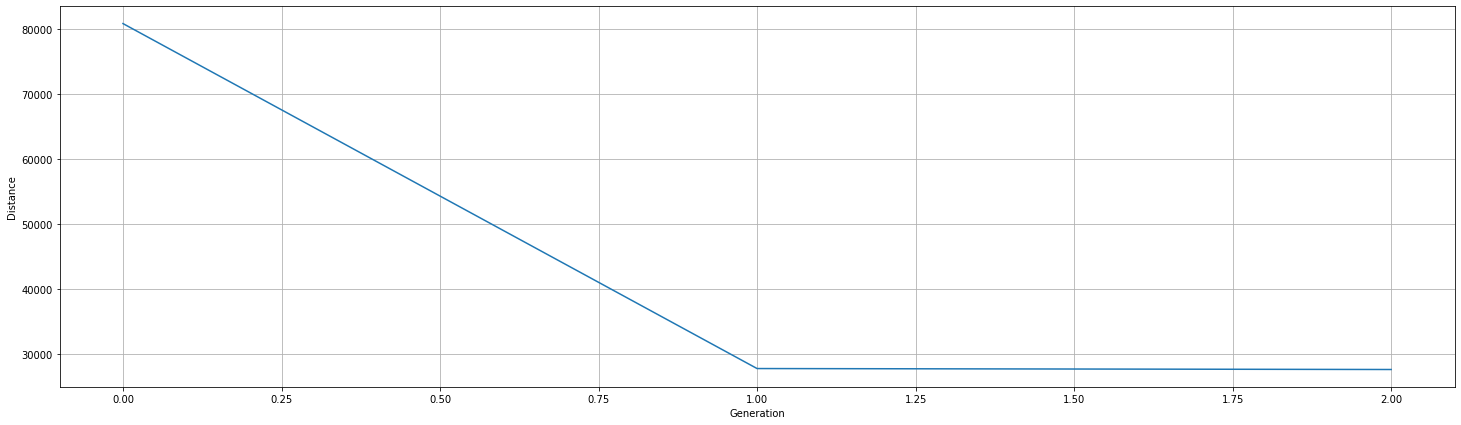

In [ ]:
GxE(VetG, VetR)

## dj38

Fazendo cruzamento e mutação sempre

In [ ]:
len(population)

200

In [ ]:
Fitness(population[0], Distances)

6656

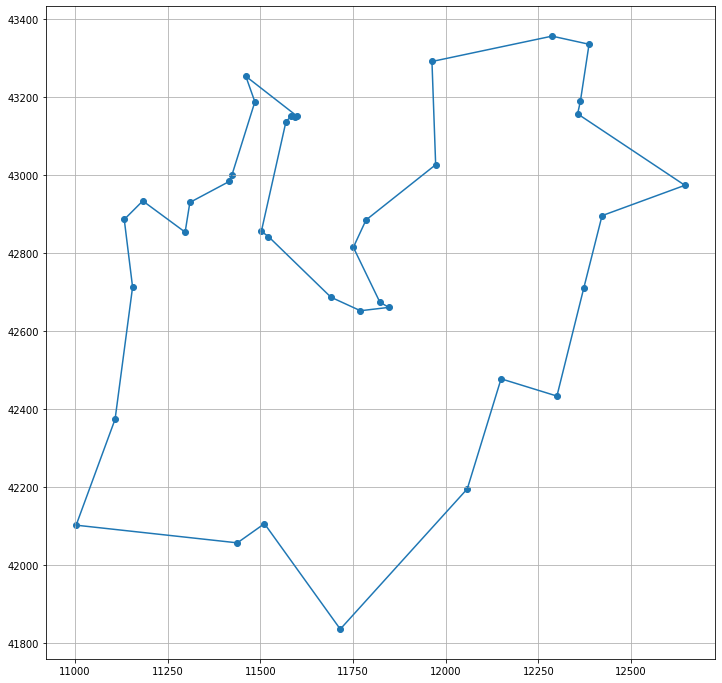

In [ ]:
showGraph(Vetor=population[0], pontos=Pt)

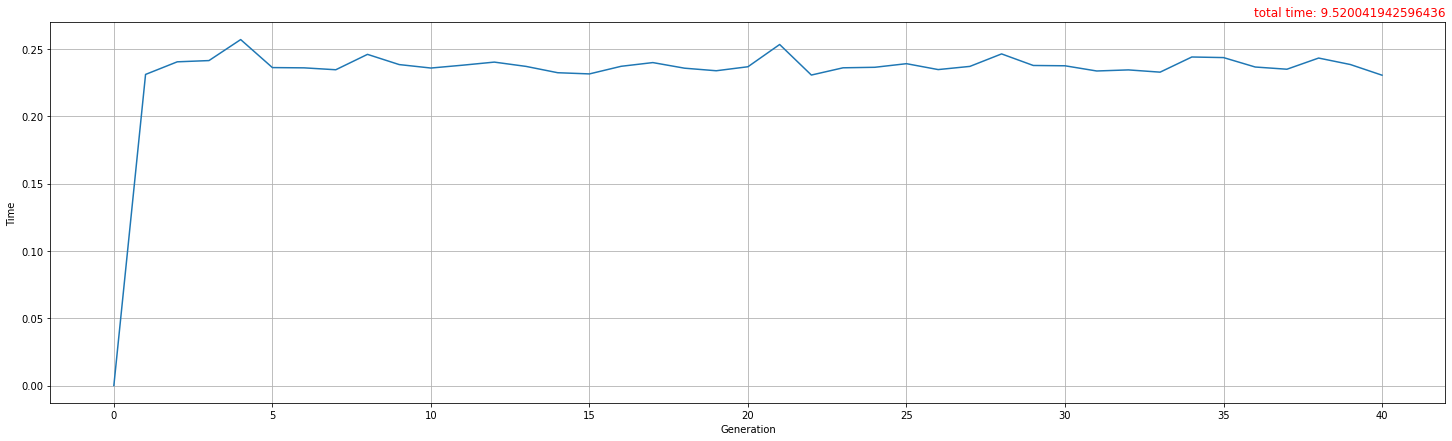

In [ ]:
GxT(VetG, VetT)

## berlin52

Fazendo cruzamento e mutação sempre

In [ ]:
len(population)

200

In [ ]:
generation

136

In [ ]:
Fitness(population[0], Distances)

7542

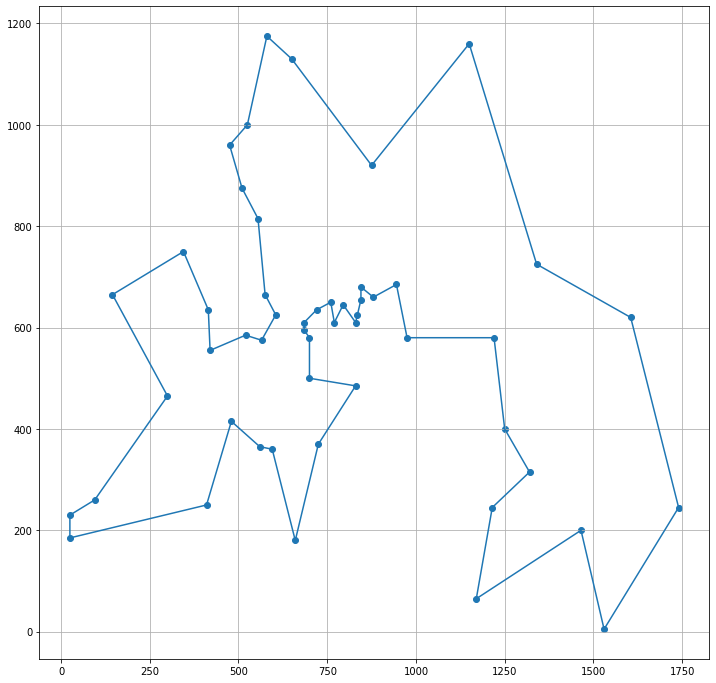

In [ ]:
showGraph(Vetor=population[0], pontos=Pt)

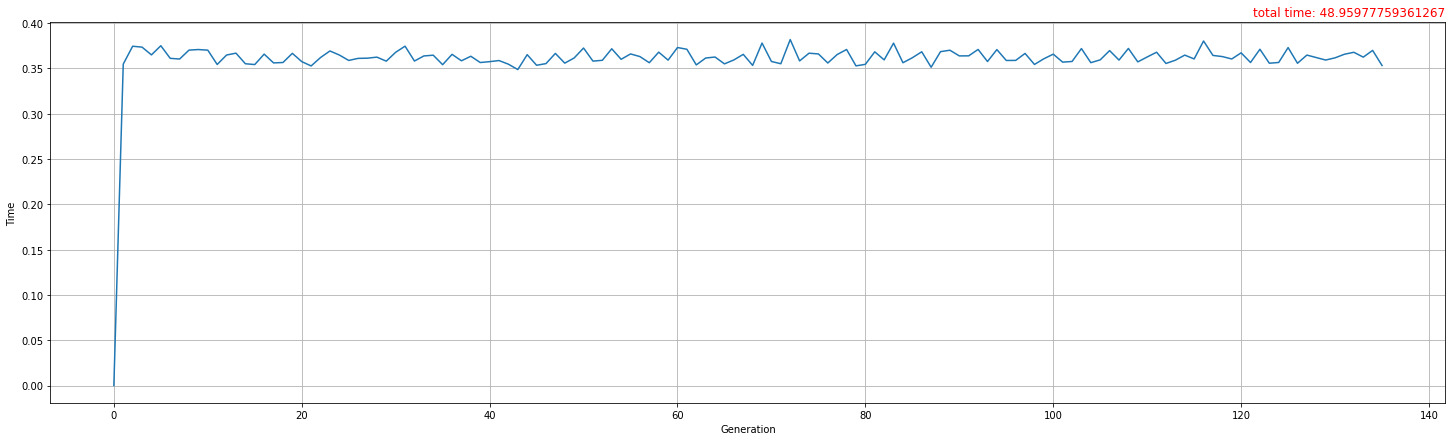

In [ ]:
GxT(VetG, VetT)

## Qatar 194

Selecionando determinados tempos pra cruzamento e mutação

In [ ]:
generation

399

In [ ]:
Fitness(population[0], Distances)

9392

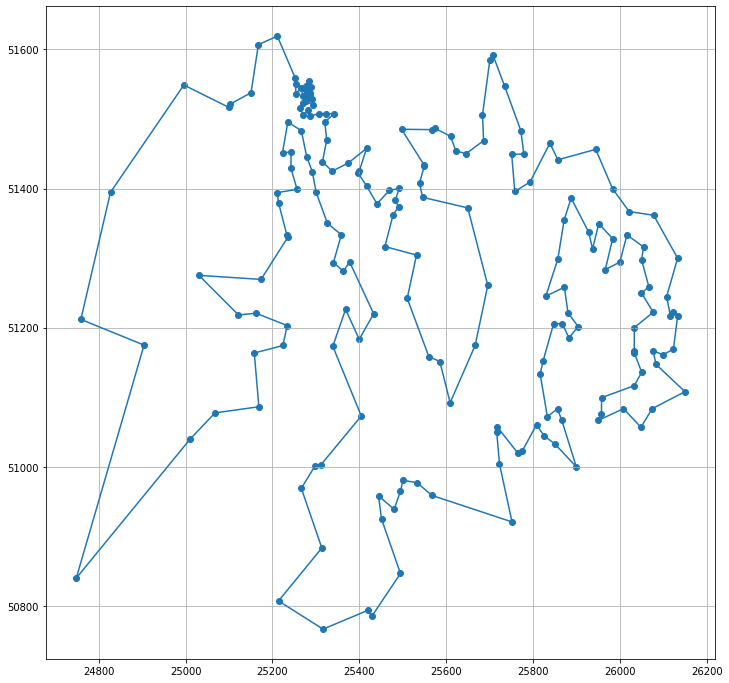

In [ ]:
showGraph(population[0], Pt)

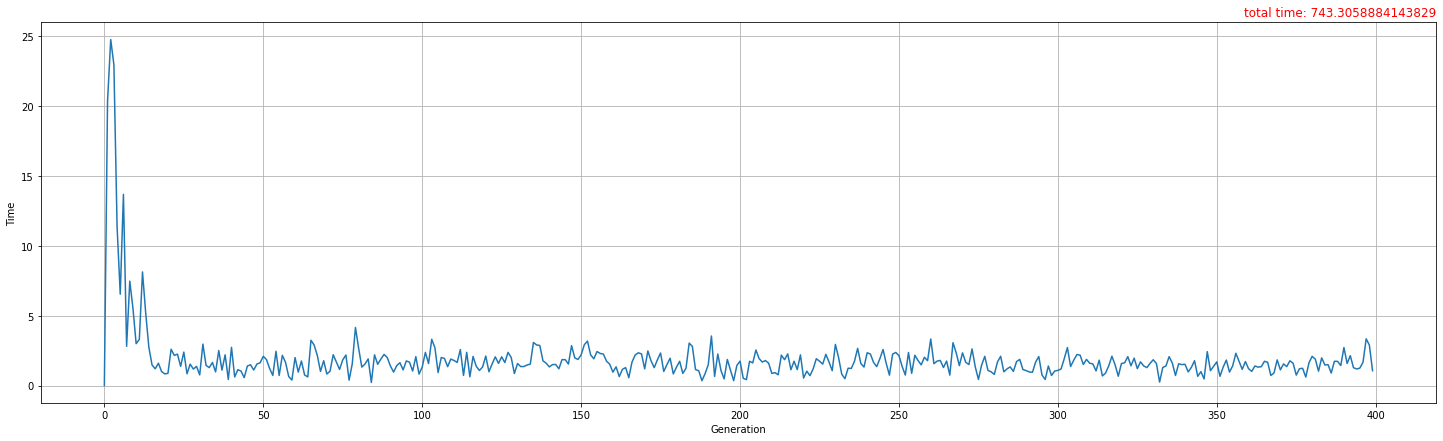

In [ ]:
GxT(VetG, VetT)

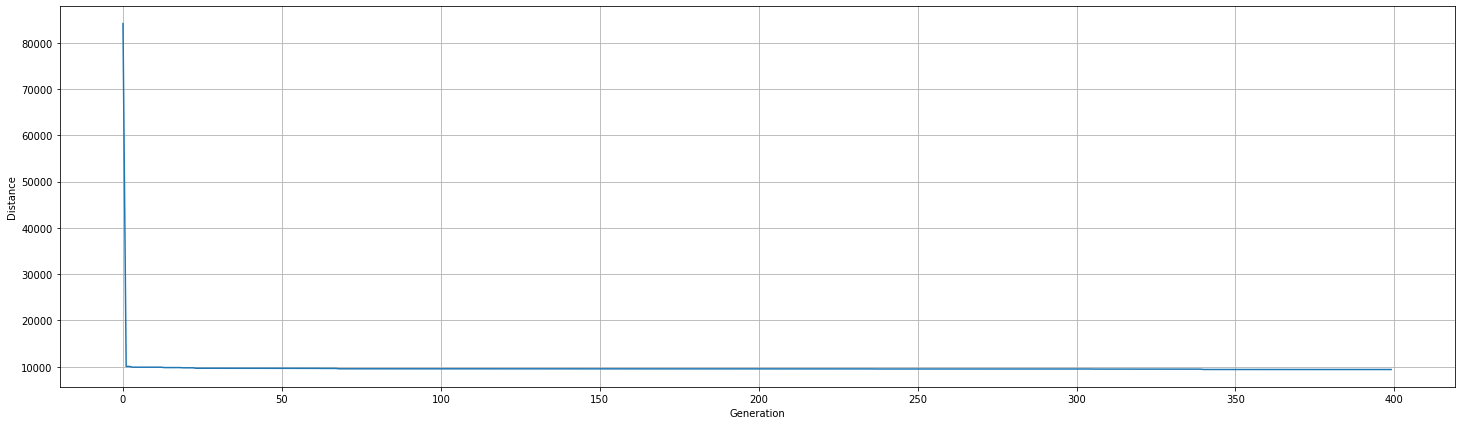

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(VetG, VetR)
plt.grid()
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.show()

## lu980

In [ ]:
Fitness(population[0], Distances)

11755

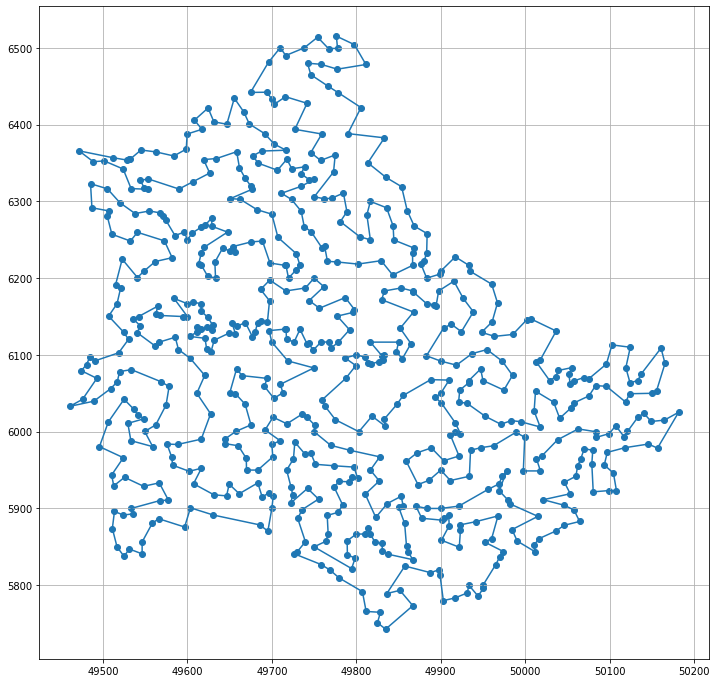

In [ ]:
showGraph(Vetor=population[0], pontos=Pt)

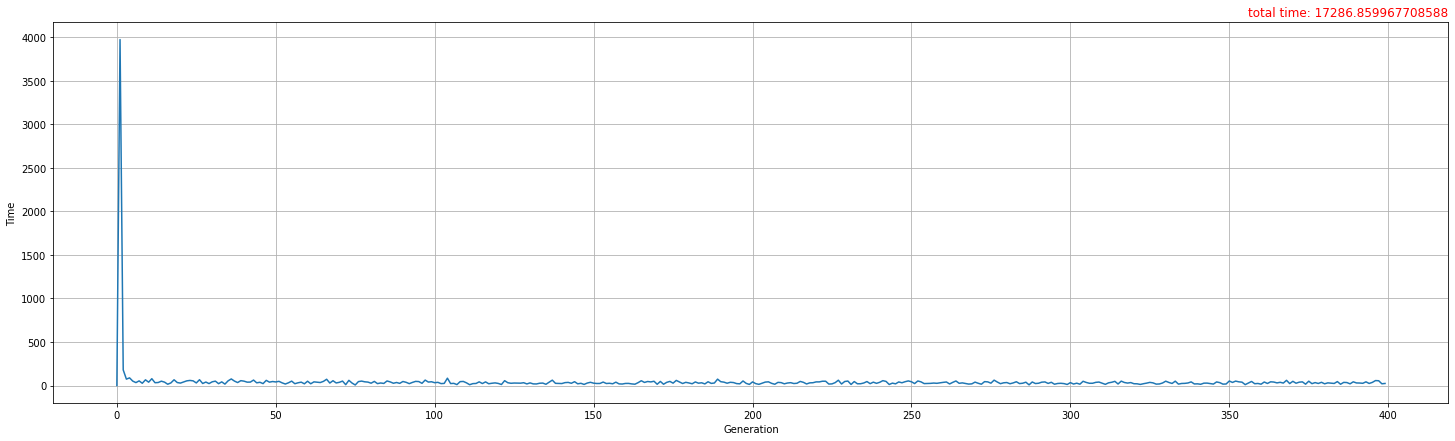

In [ ]:
GxT(VetG, VetT)

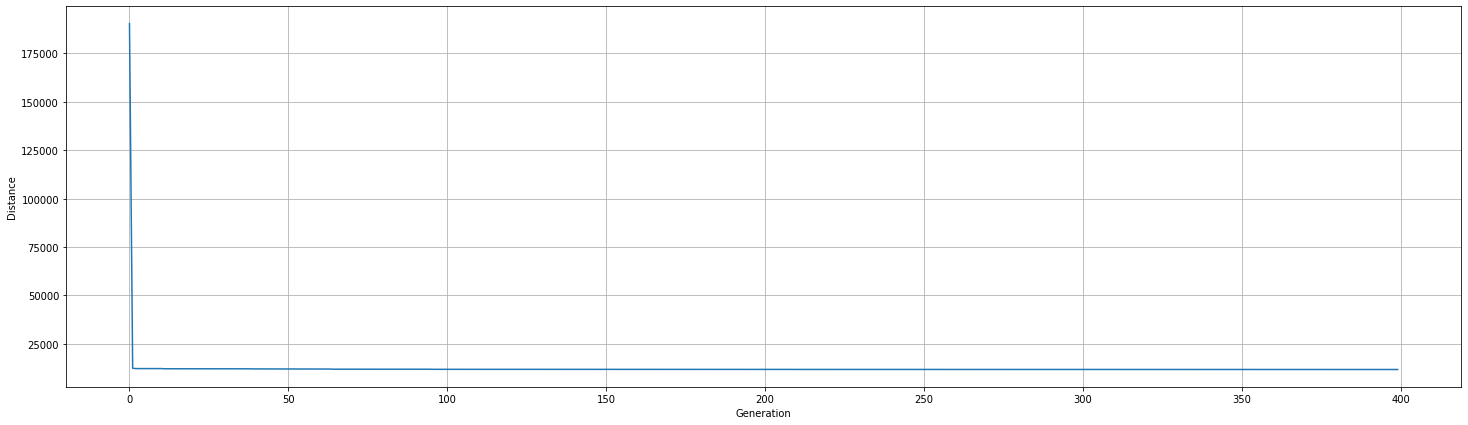

In [ ]:
GxE(VetG, VetR)

# Testes

In [ ]:
FitnessGEO(Pontos, pontos=Pontos)

3544902.196690416

In [ ]:
A = [(5.66,7.64), (3.42,5.92), (6.14, 5.72), (4.44,7.38), (6.62,6.64), (4.94,5.68)]
B = [(4.94,5.68), (4.44,7.38), (6.62,6.64), (3.42,5.92), (6.14, 5.72), (5.66,7.64)]

In [ ]:
C, D = CrossOver(A, B)

In [ ]:
print(D)

[(6.62, 6.64), (5.66, 7.64), (3.42, 5.92), (6.14, 5.72), (4.44, 7.38), (4.94, 5.68)]


In [ ]:
A[1] = (1.0, 1.0)

In [ ]:
A = [(5.66,7.64), (3.42,5.92), (6.14, 5.72), (4.44,7.38), (6.62,6.64), (4.94,5.68)]

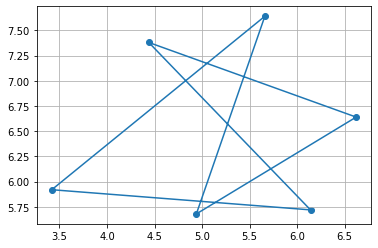

In [ ]:
showGraph(A)

In [ ]:
B = Mutation1(deepcopy(Pontos))

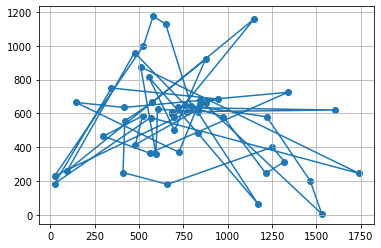

In [ ]:
showGraph(B)

In [ ]:
print(Fitness(A, pontos=A), Fitness(B, pontos=A))

14.252747512291126 10.207857730945733


# Optimal Values

In [ ]:
OptTour = []
file = open("/content/berlin52opt.txt")
for line in file:
  if line == 'EOF\n': break
  if line == '\n': continue
  aux = line.split()
  pt = int(aux[0]) - 1
  if pt not in Pt:
    OptTour.append(pt)

In [ ]:
Dist = 0
for i in range(1, 52):
  Dist += DistanceBetweenPoints(Pt[OptTour[i]], Pt[OptTour[i-1]])
  print(Dist)


In [ ]:
DistanceBetweenPoints(Pt[OptTour[46]], Pt[OptTour[45]])

290

In [ ]:
proper_round(289.9137802864845)

290.0

In [ ]:
Pt[OptTour[46]], Pt[OptTour[45]]

([300.0, 465.0], [95.0, 260.0])

In [ ]:
DistanceBetweenPoints(Pt[OptTour[0]], Pt[OptTour[1]])

64

In [ ]:
Fitness(individuo=OptTour, pontos=Distances)

7542

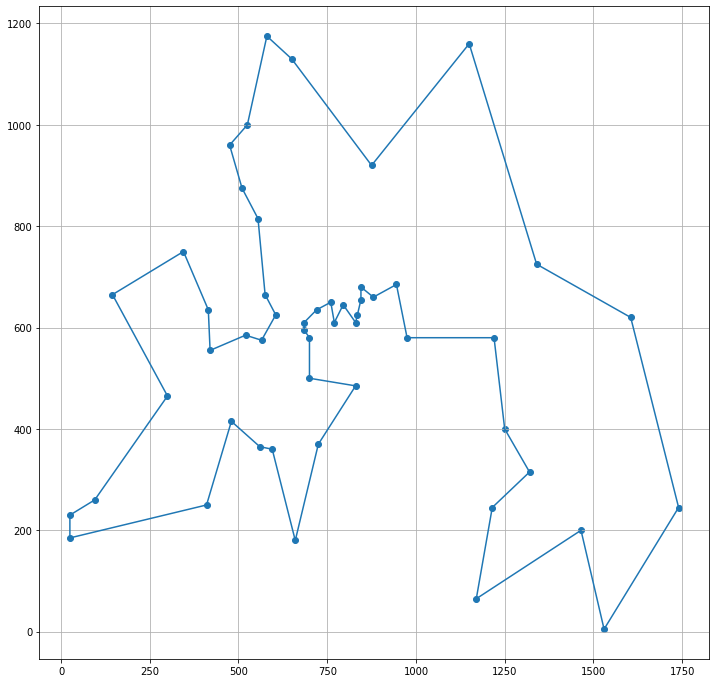

In [ ]:
showGraph(Vetor=OptTour, pontos=Pt)